## Motivation
CNN are sometimes claimed to be insensitive to image translations. Sometimes the term "shift-invariant" is used. These claims include statements such as 
> After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner.
>
In this notebook I try to verify these claim.

The dataset used is MNIST.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [38]:
image_size = x_train.shape[1]

## Network architecture
I alternate between convolution and max-pooling layers, doubling number of filters each time. I do so, until the size of feature map becomes 1x1. This way I make my best attempt to allow any region from input to affect the classification. Thus, architecture should not prevent the model from being insensitive to shifts.

I also create simple MLP model with one hidden layer. The size of hidden layer was chosen so that MLP and CNN architectures expose roughly similar amount of parameters. I do so to have a fair comparison of MLP and CNN ability to perform on shifted images.

In [172]:
def create_cnn_model():
    inputs = keras.Input(shape=(image_size, image_size, 1))
    x = inputs
    x = layers.Convolution2D(8, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Convolution2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Convolution2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Convolution2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

def create_mlp_model():
    inputs = keras.Input(shape=(image_size, image_size))
    x = inputs
    x = layers.Flatten()(x)
    # trying to have the number of parameters approximately equal to the number of params in CNN to have fair comparison
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(10, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [173]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 32)          464

In [174]:
mlp_model = create_mlp_model()
mlp_model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_29 (Flatten)        (None, 784)               0         
                                                                 
 dense_40 (Dense)            (None, 32)                25120     
                                                                 
 dense_41 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


## Training
I train 4 models:
 * MLP on original MNIST train dataset
 * MLP on randomly shifted MNIST train dataset (referred as "MLP (aug)", meaning augmented train dataset)
 * CNN on original MNIST train dataset
 * CNN on randomly shifted MNIST train dataset (referred as "CNN (aug)", meaning augmented train dataset)

In [175]:
cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history_cnn = cnn_model.fit(x_train, y_train, batch_size=512, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
118/118 [==============================] - 3s 25ms/step - loss: 0.7935 - accuracy: 0.7788 - val_loss: 0.2289 - val_accuracy: 0.9323
Epoch 2/30
118/118 [==============================] - 3s 25ms/step - loss: 0.1638 - accuracy: 0.9514 - val_loss: 0.1100 - val_accuracy: 0.9652
Epoch 3/30
118/118 [==============================] - 3s 25ms/step - loss: 0.1091 - accuracy: 0.9667 - val_loss: 0.0824 - val_accuracy: 0.9744
Epoch 4/30
118/118 [==============================] - 3s 25ms/step - loss: 0.0868 - accuracy: 0.9737 - val_loss: 0.0669 - val_accuracy: 0.9773
Epoch 5/30
118/118 [==============================] - 3s 25ms/step - loss: 0.0746 - accuracy: 0.9773 - val_loss: 0.0705 - val_accuracy: 0.9773
Epoch 6/30
118/118 [==============================] - 3s 24ms/step - loss: 0.0638 - accuracy: 0.9801 - val_loss: 0.0525 - val_accuracy: 0.9833
Epoch 7/30
118/118 [==============================] - 3s 25ms/step - loss: 0.0561 - accuracy: 0.9824 - val_loss: 0.0457 - val_accuracy: 0.9853

In [176]:
mlp_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history_mlp = mlp_model.fit(x_train, y_train, batch_size=512, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
118/118 [==============================] - 0s 2ms/step - loss: 0.8935 - accuracy: 0.7642 - val_loss: 0.4012 - val_accuracy: 0.8949
Epoch 2/30
118/118 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.9028 - val_loss: 0.3036 - val_accuracy: 0.9162
Epoch 3/30
118/118 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.9189 - val_loss: 0.2626 - val_accuracy: 0.9278
Epoch 4/30
118/118 [==============================] - 0s 2ms/step - loss: 0.2571 - accuracy: 0.9283 - val_loss: 0.2405 - val_accuracy: 0.9312
Epoch 5/30
118/118 [==============================] - 0s 2ms/step - loss: 0.2341 - accuracy: 0.9347 - val_loss: 0.2214 - val_accuracy: 0.9374
Epoch 6/30
118/118 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9393 - val_loss: 0.2115 - val_accuracy: 0.9406
Epoch 7/30
118/118 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9434 - val_loss: 0.2003 - val_accuracy: 0.9415
Epoch 

In [177]:
def show_imgs(img_arr):
    fig = plt.figure(figsize=(10, 2))
    for ind, img in enumerate(img_arr):
        reshaped = img.reshape(image_size, image_size)
        fig.add_subplot(1, len(img_arr), ind+1)
        plt.axis('off')
        plt.imshow(reshaped, cmap="Greys_r")

In [217]:
def shift_imgs(images, x, y):
    res = images # (batch, rows, cols)
    res = np.roll(res, y, axis = 1)
    res = np.roll(res, x, axis = 2)
    if y < 0:
        res[:, y:, :] = 0.0
    elif y > 0:
        res[:, :y, :] = 0.0
    if x < 0:
        res[:, :, x:] = 0.0
    elif x > 0:
        res[:, :, :x] = 0.0
    return res

In [ ]:
def random_shifts(arr, shift_fn):
    result = np.copy(arr)
    discr = np.rint(np.random.rand(result.shape[0]) * 12 - 6).astype(int)
    for v in np.unique(discr):
        result[discr == v] = shift_fn(result[discr == v], v)
    return result

In [255]:
x_train_random_shift = x_train
x_train_random_shift = random_shifts(x_train_random_shift, lambda x, s: shift_imgs(x, s, 0))
x_train_random_shift = random_shifts(x_train_random_shift, lambda x, s: shift_imgs(x, 0, s))

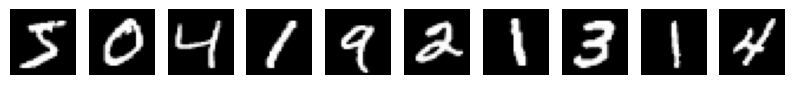

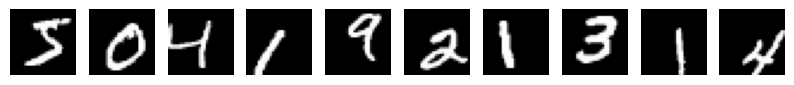

In [256]:
show_imgs(x_train[:10])
show_imgs(x_train_random_shift[:10])

In [263]:
mlp_model_augmented = create_mlp_model()
mlp_model_augmented.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history_mlp_augmented = mlp_model_augmented.fit(x_train_random_shift, y_train, batch_size=512, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
118/118 [==============================] - 0s 2ms/step - loss: 1.9023 - accuracy: 0.3641 - val_loss: 1.4500 - val_accuracy: 0.5851
Epoch 2/30
118/118 [==============================] - 0s 1ms/step - loss: 1.3433 - accuracy: 0.5904 - val_loss: 1.0807 - val_accuracy: 0.6964
Epoch 3/30
118/118 [==============================] - 0s 1ms/step - loss: 1.0530 - accuracy: 0.6811 - val_loss: 0.8746 - val_accuracy: 0.7515
Epoch 4/30
118/118 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.7320 - val_loss: 0.7539 - val_accuracy: 0.7929
Epoch 5/30
118/118 [==============================] - 0s 4ms/step - loss: 0.7867 - accuracy: 0.7659 - val_loss: 0.6691 - val_accuracy: 0.8095
Epoch 6/30
118/118 [==============================] - 0s 2ms/step - loss: 0.7110 - accuracy: 0.7910 - val_loss: 0.6096 - val_accuracy: 0.8237
Epoch 7/30
118/118 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.8080 - val_loss: 0.5550 - val_accuracy: 0.8416
Epoch 

In [257]:
cnn_model_augmented = create_cnn_model()
cnn_model_augmented.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
history_cnn_augmented = cnn_model_augmented.fit(x_train_random_shift, y_train, batch_size=512, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
118/118 [==============================] - 4s 27ms/step - loss: 1.1588 - accuracy: 0.6333 - val_loss: 0.3851 - val_accuracy: 0.8842
Epoch 2/30
118/118 [==============================] - 3s 25ms/step - loss: 0.3825 - accuracy: 0.8840 - val_loss: 0.2390 - val_accuracy: 0.9282
Epoch 3/30
118/118 [==============================] - 3s 26ms/step - loss: 0.2787 - accuracy: 0.9149 - val_loss: 0.1827 - val_accuracy: 0.9443
Epoch 4/30
118/118 [==============================] - 3s 25ms/step - loss: 0.2217 - accuracy: 0.9328 - val_loss: 0.1583 - val_accuracy: 0.9491
Epoch 5/30
118/118 [==============================] - 3s 25ms/step - loss: 0.1886 - accuracy: 0.9418 - val_loss: 0.1478 - val_accuracy: 0.9549
Epoch 6/30
118/118 [==============================] - 3s 25ms/step - loss: 0.1677 - accuracy: 0.9490 - val_loss: 0.1221 - val_accuracy: 0.9612
Epoch 7/30
118/118 [==============================] - 3s 25ms/step - loss: 0.1478 - accuracy: 0.9540 - val_loss: 0.1127 - val_accuracy: 0.9634

## Performance on shifted test set
Let's check how our models perform on test set (which they haven't been trained on) which was shifted.

Starting with some small constant shift on both axes...

In [264]:
print(f'MLP accuracy with shifted images: {mlp_model.evaluate(shift_imgs(x_test, 3, 3), y_test, verbose=0)[1]}')
print(f'MLP (aug) accuracy with shifted images: {mlp_model_augmented.evaluate(shift_imgs(x_test, 3, 3), y_test, verbose=0)[1]}')
print(f'CNN accuracy with shifted images: {cnn_model.evaluate(shift_imgs(x_test, 3, 3), y_test, verbose=0)[1]}')
print(f'CNN (aug) accuracy with shifted images: {cnn_model_augmented.evaluate(shift_imgs(x_test, 3, 3), y_test, verbose=0)[1]}')

MLP accuracy with shifted images: 0.1688999980688095
MLP (aug) accuracy with shifted images: 0.8906000256538391
CNN accuracy with shifted images: 0.6712999939918518
CNN (aug) accuracy with shifted images: 0.9807999730110168


Ouch! While huge drop for MLP was expected, non-augmented CNN failed as well!

Also note, how augmented version of both MLP and CNN sustain decent accuracy.

Let's explore more details here.

In [265]:
mlp_horiz_acc = []
mlp_aug_horiz_acc = []
cnn_horiz_acc = []
cnn_aug_horiz_acc = []
for shift_horiz in range(0, 6):
    mlp_horiz_acc.append(mlp_model.evaluate(shift_imgs(x_test, shift_horiz, 0), y_test, verbose=0)[1])
    mlp_aug_horiz_acc.append(mlp_model_augmented.evaluate(shift_imgs(x_test, shift_horiz, 0), y_test, verbose=0)[1])
    cnn_horiz_acc.append(cnn_model.evaluate(shift_imgs(x_test, shift_horiz, 0), y_test, verbose=0)[1])
    cnn_aug_horiz_acc.append(cnn_model_augmented.evaluate(shift_imgs(x_test, shift_horiz, 0), y_test, verbose=0)[1])

mlp_vert_acc = []
mlp_aug_vert_acc = []
cnn_vert_acc = []
cnn_aug_vert_acc = []
for shift_vert in range(0, 6):
    mlp_vert_acc.append(mlp_model.evaluate(shift_imgs(x_test, 0, shift_vert), y_test, verbose=0)[1])
    mlp_aug_vert_acc.append(mlp_model_augmented.evaluate(shift_imgs(x_test, 0, shift_vert), y_test, verbose=0)[1])
    cnn_vert_acc.append(cnn_model.evaluate(shift_imgs(x_test, 0, shift_vert), y_test, verbose=0)[1])
    cnn_aug_vert_acc.append(cnn_model_augmented.evaluate(shift_imgs(x_test, 0, shift_vert), y_test, verbose=0)[1])

In [267]:
print('Accuracy when shifting:')
for shift in range(0, len(cnn_horiz_acc)):
    print(f'{shift} pixels: MLP horiz {mlp_horiz_acc[shift]:.3f} vert {mlp_vert_acc[shift]:.3f}, ' + \
          f'MLP (aug) horiz {mlp_aug_horiz_acc[shift]:.3f} vert {mlp_aug_vert_acc[shift]:.3f}, ' + \
         f'CNN horiz {cnn_horiz_acc[shift]:.3f} vert {cnn_vert_acc[shift]:.3f}, ' + \
         f'CNN (aug) horiz {cnn_aug_horiz_acc[shift]:.3f} vert {cnn_aug_vert_acc[shift]:.3f}')

Accuracy when shifting:
0 pixels: MLP horiz 0.964 vert 0.964, MLP (aug) horiz 0.884 vert 0.884, CNN horiz 0.987 vert 0.987, CNN (aug) horiz 0.981 vert 0.981
1 pixels: MLP horiz 0.930 vert 0.919, MLP (aug) horiz 0.882 vert 0.889, CNN horiz 0.982 vert 0.980, CNN (aug) horiz 0.980 vert 0.981
2 pixels: MLP horiz 0.752 vert 0.693, MLP (aug) horiz 0.888 vert 0.888, CNN horiz 0.967 vert 0.952, CNN (aug) horiz 0.979 vert 0.978
3 pixels: MLP horiz 0.479 vert 0.350, MLP (aug) horiz 0.892 vert 0.888, CNN horiz 0.927 vert 0.869, CNN (aug) horiz 0.977 vert 0.977
4 pixels: MLP horiz 0.324 vert 0.127, MLP (aug) horiz 0.884 vert 0.892, CNN horiz 0.839 vert 0.734, CNN (aug) horiz 0.978 vert 0.977
5 pixels: MLP horiz 0.220 vert 0.062, MLP (aug) horiz 0.863 vert 0.871, CNN horiz 0.696 vert 0.561, CNN (aug) horiz 0.978 vert 0.974


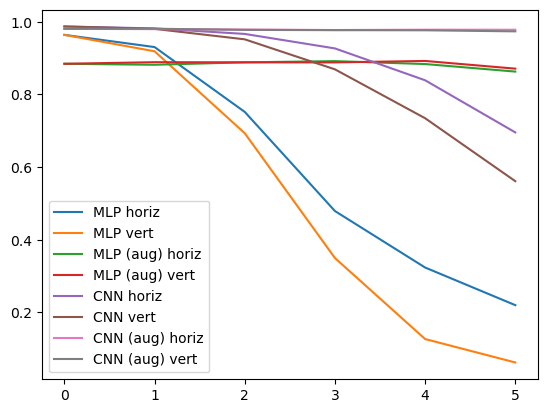

In [268]:
plt.plot(mlp_horiz_acc, label='MLP horiz')
plt.plot(mlp_vert_acc, label='MLP vert')
plt.plot(mlp_aug_horiz_acc, label='MLP (aug) horiz')
plt.plot(mlp_aug_vert_acc, label='MLP (aug) vert')
plt.plot(cnn_horiz_acc, label='CNN horiz')
plt.plot(cnn_vert_acc, label='CNN vert')
plt.plot(cnn_aug_horiz_acc, label='CNN (aug) horiz')
plt.plot(cnn_aug_vert_acc, label='CNN (aug) vert')
plt.legend()

# Conclusion

Vanilla CNN implementation with max-pooling is not shift-invariant. When trained on non-shifted dataset, it totally fails to generalize to image shifts when classifying digits. Even minimal shift of 1 pixel results in noticeable drop in accuracy. And with larger shifts accuracy becomes unacceptable.

At the same time, when trained on shifted dataset, CNN performs very well on shifted test set, losing very little accuracy. This proves, that shifts are not fundamental issue for CNN, it is capable of handling them, but only when explicitly learning such patterns from training set. We should not expect CNN to perform well on shifted images by default.

In this regard, CNN is not that different from regular MLP. When specifically trained on shifted train set, MLP is robust to shifts in new data. When not trained specifically for such patterns, its accuracy quickly drops even with small shifts.

Thus, the advantage of CNNs over MLP is not automatic shift robustness. But rather the ability to generalize well when observing different locations of same pattern in train data. You can see it by performance of augmented MLP and CNN on non-shifted test set. In order to learn different shifts in train data, both augmented MLP and augmented CNN had to sacrifice their performance on non-shifted data. But the amount of the drop is so different! MLP: 0.964 -> 0.884, CNN: 0.987 -> 0.981. Remember, they have approximately similar amount of parameters, but CNN is so much more effective at learning all these shifted patterns.

To be fair, non-augmented CNN is indeed more robust to shifts than non-augmented MLP. But the actual accuracies of them are so low, that this observation lacks any practical value. And this kind of performance is far from being considered "shift-invariant" or "translation insensitive".

Additional observation is that vertical shift is more harmful than horizontal for both non-augmented CNN and non-augmented MLP.

One final note on the terminology and claims. It seems that there can be confusion about "shift-invariance" term. While this notebook shows that CNN as a model is not "shift-invariant", the claim that a single convolution layer is shift-invariant is still true. In this case it has another meaning: the shift in layer's input is preserved in layer's output.